### Import Modules

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout

Using TensorFlow backend.


### Load lines from CSV file and split Train/Test

In [2]:
# Are you using AWS?
# Are you using Ricky's driving data?
aws = False
ricky = False

if aws:
    csv_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
                '/carnd-behavioral-cloning-p3/data/driving_log.csv'
    image_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
                '/carnd-behavioral-cloning-p3/data/IMG/'
else:
    if ricky:
        csv_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\driving_log.csv"
        image_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\IMG\\"
    else:
        csv_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\driving_log.csv"
        image_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\IMG\\"

lines = []
with tqdm(open(csv_path)) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)
        
# Check if our CSV list is empty
assert len(lines) > 0
assert len(lines[0]) == 7

train_samples, validation_samples = train_test_split(lines, test_size=0.2)

8037it [00:00, 236218.92it/s]


### Create Generator Function

In [3]:
def generator(samples, batch_size=16):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                source_path = batch_sample[0]
                filename = source_path.split('/')[-1]
                image_path_list = image_path + filename
#                 print('source path\t{}\n' \
#                       'filename\t{}\n' \
#                       'image_path\t{}\n' \
#                       'image_path_list\t{}\n\n'.format(source_path, filename, image_path, image_path_list))
                image = cv2.imread(image_path_list)
                assert image !=None, 'Looks like you may have the wrong IMG destination'
#                 plt.imshow(image)
#                 plt.show()
                images.append(image)
                angle = float(batch_sample[3])
                angles.append(angle)
                
                # Flip images and steering angles
                if angle == 0.0: continue
                images.append(cv2.flip(image, 1))
                angles.append(angle*-1.0)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Plot Initial Distribution

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(43, 160, 320, 3)
(43,)


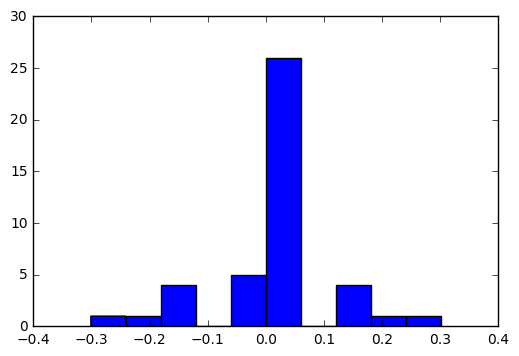

[[[[173 134 106]
   [173 134 106]
   [173 134 106]
   ..., 
   [233 181 141]
   [231 182 142]
   [229 183 142]]

  [[173 134 106]
   [173 134 106]
   [173 134 106]
   ..., 
   [244 193 160]
   [213 166 134]
   [230 185 152]]

  [[174 135 107]
   [174 135 107]
   [174 135 107]
   ..., 
   [235 191 168]
   [212 173 151]
   [218 184 161]]

  ..., 
  [[ 94 108 107]
   [108 122 121]
   [116 130 129]
   ..., 
   [140 161 163]
   [150 171 173]
   [157 178 180]]

  [[130 144 143]
   [115 129 128]
   [102 116 115]
   ..., 
   [143 164 166]
   [144 165 167]
   [146 167 169]]

  [[ 98 112 111]
   [ 99 113 112]
   [109 123 122]
   ..., 
   [149 170 172]
   [153 174 176]
   [157 178 180]]]


 [[[203 159 128]
   [203 159 128]
   [203 159 128]
   ..., 
   [178 171 138]
   [179 174 141]
   [175 170 137]]

  [[203 159 128]
   [203 159 128]
   [203 159 128]
   ..., 
   [ 84  87  62]
   [160 164 139]
   [164 170 145]]

  [[204 160 129]
   [204 160 129]
   [204 160 129]
   ..., 
   [108 128 116]
   [ 93 1

In [4]:
# print(train_geneartor)
# next(train_geneartor)
X, y = next(train_generator)
print(X.shape)
print(y.shape)
plt.hist(y)
plt.show()
print(X)

### Parse CSV file

In [5]:
# images = []
# measurements = []
# for line in tqdm(lines):
#     source_path = line[0]
#     filename = source_path.split('/')[-1]
#     image_path_list = image_path + '/' + filename
#     image = cv2.imread(image_path_list)
#     images.append(image)
#     measurement = float(line[3])
#     measurements.append(measurement)

### Flip Image and Steering Angle

In [6]:
# augmented_images, augmented_measurements = [], []
# for image, measurement in zip(images, measurements):
#     augmented_images.append(image)
#     augmented_measurements.append(measurement)
#     # Avoid adding all angles that are at 0.0
#     if measurement == 0.0: continue
#     augmented_images.append(cv2.flip(image, 1))
#     augmented_measurements.append(measurement*-1.0)

### Construct Model

In [7]:
# batch_size = 32

# X_train = np.array(augmented_images)
# y_train = np.array(augmented_measurements)

# X_train = np.array(images)
# y_train = np.array(measurements)

# Model 1 - barebones model
# model = Sequential()
# model.add(Flatten(input_shape=(160,320,3)))
# model.add(Dense(128))
# model.add(Dense(84))
# model.add(Dense(1))

# Model 2
# model = Sequential()
# model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
# model.add(Convolution2D(32,3,3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(Convolution2D(16, 3, 3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(84))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))

# Model 3
model = Sequential()
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(64,3,3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Convolution2D(16, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

### Train, Validate, and Save Model

In [8]:
model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, batch_size=batch_size)

nb_val_samples = len(validation_samples)
nb_epoch = 5

# Complie modile with Generator
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), \
                   validation_data=validation_generator, \
                   nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, \
                   verbose=1)

model.save('model-udacity-data.h5')
print('model {} saved'.format(model.__str__))

Epoch 1/5


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


6393/6428 [============================>.] - ETA: 1s - loss: 0.0180

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6448/6428 [==============================] - 248s - loss: 0.0180 - val_loss: 0.0127
Epoch 2/5
6472/6428 [==============================] - 246s - loss: 0.0147 - val_loss: 0.0118
Epoch 3/5
6467/6428 [==============================] - 260s - loss: 0.0140 - val_loss: 0.0104
Epoch 4/5
6428/6428 [==============================] - 257s - loss: 0.0130 - val_loss: 0.0111
Epoch 5/5
6429/6428 [==============================] - 259s - loss: 0.0129 - val_loss: 0.0111
model <method-wrapper '__str__' of Sequential object at 0x000000DF40D3D0B8> saved


### Analyze how well the model does

In [9]:
print(history_object.history.keys())

dict_keys(['loss', 'val_loss'])


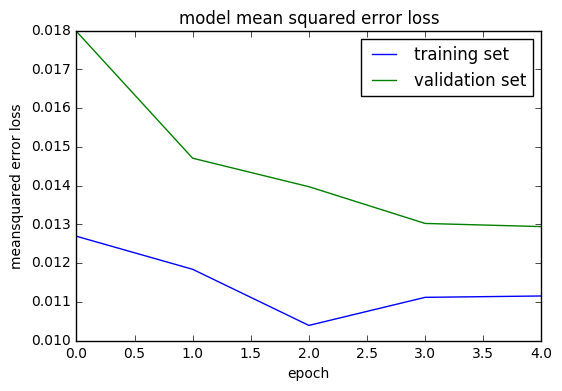

In [10]:
plt.plot(history_object.history['val_loss'])
plt.plot(history_object.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('meansquared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()